In [110]:
import math
import numpy as np
from IPython.display import clear_output
import pdb
import time

import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
from torchdiffeq import odeint_adjoint as odeint
from torch.distributions import MultivariateNormal
use_cuda = torch.cuda.is_available()
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import gc
import importlib
import Utils
importlib.reload(Utils)
from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory
from Utils import SaveTrajectory as st
import ODEModel
importlib.reload(ODEModel)
from ODEModel import ODEfunc
from ODEModel import FfjordModel
import LearnTraj
importlib.reload(LearnTraj);
from LearnTraj import learn_trajectory

##
# import math
# import numpy as np
# from IPython.display import clear_output
# import pdb
# import time

# import matplotlib.pyplot as plt

# import torch
# from torch import Tensor
# from torch import nn
# from torch.nn  import functional as F 
# from torch.autograd import Variable
# from torchdiffeq import odeint_adjoint as odeint
# from torch.distributions import MultivariateNormal
# use_cuda = torch.cuda.is_available()
# from geomloss import SamplesLoss
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# import gc
# import importlib
# import Utils
# from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory
# from Utils import SaveTrajectory as st
# import ODEModel
# from ODEModel import ODEfunc
# from ODEModel import FfjordModel


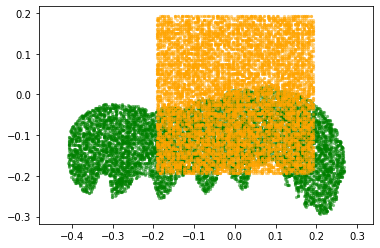

In [111]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
caterpillar = 1-ImageDataset.import_img('caterpillar.png'); caterpillar/=caterpillar.max();
butterfly = 255-ImageDataset.import_img('butterfly.jpg'); butterfly/=butterfly.max();
circle = 255-ImageDataset.import_img('circle.jpeg'); circle/=circle.max();
square = 1-ImageDataset.import_img('square.png'); square/=square.max();
dset1 = ImageDataset(img=caterpillar*1,thresh=.8); 
dset2 = ImageDataset(img=butterfly*1,thresh=.8)
dset3 = ImageDataset(img=circle*1,thresh=.8)
dset4 = ImageDataset(img=square*1,thresh=.8)

n = 10000; 
dat1 = dset1.sample(n); 
dat2 = dset2.sample(n); 
dat3 = dset3.sample(n)*.7;
dat4 = dset4.sample(n);
dat1*=-1; dat1[:,1]-=.1;
dat2*=-1; dat2[:,1]+=.5; 
dat3[:,1]+=.1;

plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='green')
# plt.scatter(dat2.detach().numpy()[:,0],dat2.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='red')
# plt.scatter(dat3.detach().numpy()[:,0],dat3.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='magenta')
plt.scatter(dat4.detach().numpy()[:,0],dat4.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='orange')
plt.axis('equal')
plt.show() 

training with sinkhorn_large_reg
0.001
batch 0 loss tensor(2., device='cuda:0', grad_fn=<AddBackward0>)


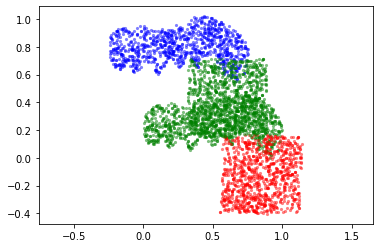

fit time  0.09251976013183594  reg loss time 0.005918979644775391
time elapsed 0.644505500793457 total time 0.6444602012634277
batch number 0 out of 900
0.001
batch 30 loss tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)


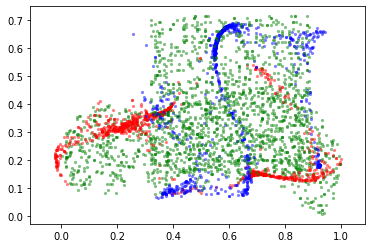

fit time  0.11850500106811523  reg loss time 0.005326032638549805
time elapsed 16.103939533233643 total time 21.526650428771973
batch number 30 out of 900
0.001
batch 60 loss tensor(0.0071, device='cuda:0', grad_fn=<AddBackward0>)


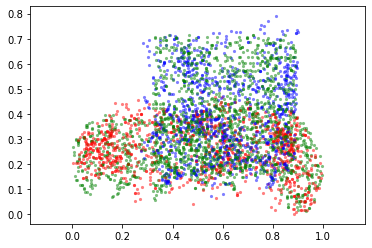

fit time  0.10107254981994629  reg loss time 0.0053997039794921875
time elapsed 14.78064250946045 total time 41.18629169464111
batch number 60 out of 900
0.001
batch 90 loss tensor(0.0129, device='cuda:0', grad_fn=<AddBackward0>)


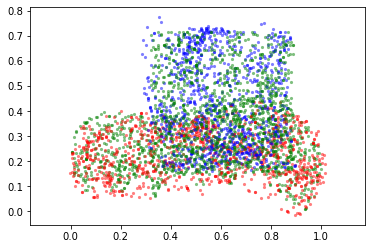

fit time  0.10099267959594727  reg loss time 0.005416393280029297
time elapsed 13.645214319229126 total time 59.59123516082764
batch number 90 out of 900


TypeError: unsupported operand type(s) for ^: 'float' and 'float'

<Figure size 432x288 with 0 Axes>

In [112]:
z_target = ImageDataset.normalize_samples(torch.stack((dat1, dat4)).to(device));
model = FfjordModel(); 
# model.load_state('models/seq_state420_time_31.615391731262207.tar');
# model.load_state('models/state310_time_22.49951934814453.tar');
# model.load_state('models/state_start11.tar');
# for my_loss in ['sinkhorn_small_reg']:
# my_loss = 'sinkhorn_small_reg';
my_loss = 'sinkhorn_large_reg';
# %prun 
model, losses, separate_losses = learn_trajectory(z_target, my_loss=my_loss,n_iters = 900,n_subsample=1000, model=model, save=True)
st.save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=500)
st.save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=500,reverse=True)

1442

In [ ]:
st.save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=500)
st.save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=500,reverse=True)

<class 'torch.Tensor'> torch.Size([512, 143])
torch.Size([140])


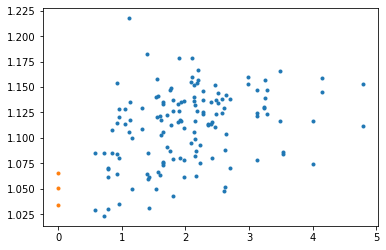

In [96]:
# test what weights are given to what frequencies in the first layer
for param in model.parameters():
    print(type(param.data), param.size())
    pdat = param.data;
    break;    
pmags = torch.norm(param.data,p=2,dim=0);
freqs = model.time_deriv_func.imap.B;
nf = freqs.shape[0];
nd = (pmags.shape[0]-2*nf)

fmags = torch.norm(freqs,p=2,dim=1);
xyfreqs = torch.cat([fmags, fmags],dim=0);
print(xyfreqs.size())

plt.plot(xyfreqs.cpu().numpy(), pmags[0:(nf*2)].cpu().numpy(),'.')
plt.plot(np.zeros(nd), pmags[(nf*2):].cpu().numpy(),'.')

# # freqs
# # fmags

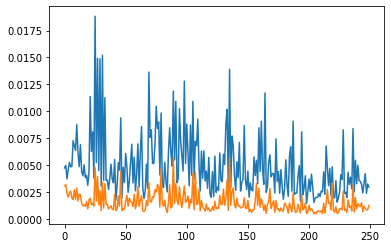

In [95]:
plt.plot(losses[1:]); 
plt.plot(separate_losses[0,50:]); 
plt.plot(separate_losses[1,50:]); 
# plt.plot(separate_losses[2,50:]); 
# plt.plot(separate_losses[3,50:]); 
# plt.plot(separate_losses[4,50:]); 
# plt.plot(separate_losses[5,50:]); 
# plt.plot(separate_losses[6,0:]);
plt.show()

In [98]:
## visualize ending sinkhorn costs as gradient on point clouds
# z_target = ImageDataset.normalize_samples(torch.stack((dat1,dat4)).to(device));
T = z_target.shape[0];

z_t = model(z_target[0,:,:], integration_times = torch.linspace(0,1,2).to(device),reverse=False);
z_t_b = model(z_target[T-1,:,:], integration_times = torch.linspace(0,1,2).to(device),reverse=True);
forward = z_t[T-1,:,:].cpu().detach().numpy();
backward = z_t_b[T-1,:,:].cpu().detach().numpy();

my_loss_f = SamplesLoss("sinkhorn", p=2, blur=0.01);
loss_f = my_loss_f(z_target[T-1,:,:], z_t[T-1,:,:])
loss_b = my_loss_f(z_target[0,:,:], z_t_b[T-1,:,:])

graddirs_f = torch.autograd.grad(loss_f, z_t)[0][T-1,:,:]
graddirs_b = torch.autograd.grad(loss_b, z_t_b)[0][T-1,:,:]

pos_f = z_t.cpu().detach().numpy()
pos_b = z_t_b.cpu().detach().numpy()
dirs_f = graddirs_f.cpu().detach().numpy()
dirs_b = graddirs_b.cpu().detach().numpy()

import os
plt.axis('equal')
plt.scatter(pos_b[0,:,0], pos_b[0,:,1], s=10, alpha=.5, linewidths=0, c='green', edgecolors='black')
plt.scatter(forward[:,0], forward[:,1], s=10, alpha=.5, linewidths=0, c='red', edgecolors='black')
plt.quiver(pos_f[T-1,:,0], pos_f[T-1,:,1], dirs_f[:,0], dirs_f[:,1],scale=.0001)
plt.savefig(os.path.join('./', f"viz_backward.jpg"),dpi=400); plt.clf()

plt.axis('equal')
plt.scatter(pos_f[0,:,0], pos_f[0,:,1], s=10, alpha=.5, linewidths=0, c='green', edgecolors='black')
plt.scatter(backward[:,0], backward[:,1], s=10, alpha=.5, linewidths=0, c='red', edgecolors='black')
plt.quiver(pos_b[T-1,:,0], pos_b[T-1,:,1], dirs_b[:,0], dirs_b[:,1],scale=.0001)
plt.savefig(os.path.join('./', f"viz_forward.jpg"),dpi=400); plt.clf()


<Figure size 432x288 with 0 Axes>

(tensor(0.0290, device='cuda:0'), tensor(0.0290, device='cuda:0'))

In [ ]:
#trying other shapes

square = np.zeros([20,20])
square[6:14,:8] = 1

two_square = np.zeros([20,20])
two_square[:5,14:] = 1
two_square[15:,14:] = 1


annulus = import_img('annulus.png')
circle = 255-import_img('circle.jpeg')

dset = ImageDataset(img=square)
dset1 = ImageDataset(img=two_square)

n = 500
dat = dset.sample(n)
dat1 = dset1.sample(n)
plt.scatter(dat.detach().numpy()[:,0],dat.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='red')
plt.show() 

In [ ]:
# make half moon dataset
import sklearn.datasets

moons, labels = sklearn.datasets.make_moons(n,noise=.1) #generates two half moons
mask = (labels == 0)
one_moon = moons[mask,:] # only keep one moon

def rot_mat(theta0):
    #computes rotation matrix of angle theta
    return np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])

theta0 = np.pi/2
theta1 = np.pi

rot0 = rot_mat(theta0)
rot1 = rot_mat(theta1)

# apply rotation to the moon
one_moon_rot0 = np.dot(one_moon,rot0)
one_moon_rot1 = np.dot(one_moon,rot1)

In [ ]:
#visualize rotated moons

plt.scatter(one_moon[:,0],one_moon[:,1], color='blue')
plt.scatter(one_moon_rot0[:,0],one_moon_rot0[:,1], color='orange')
plt.scatter(one_moon_rot1[:,0],one_moon_rot1[:,1], color='green')

In [ ]:
# with three timesteps

dat = torch.tensor(one_moon,dtype=torch.float)
dat0 = torch.tensor(one_moon_rot0,dtype=torch.float)
dat1 = torch.tensor(one_moon_rot1,dtype=torch.float)

dat_tuple = (dat,dat0,dat1)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
# with two timesteps


dat_tuple = (dat,dat0)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
losses